<img src="https://www.rochester.edu/assets/images/ur-logo.svg">

# <center>[CSC 249/449: Machine Vision](https://www.cs.rochester.edu/~cxu22/t/249F20/)</center>

## Homework Submission
After completed the homework notebook. 
- Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`, as well as your NetID below.
- `Kernel`$\rightarrow$ `Restart & Run All` (in the menubar).
- You can generated zip file using following command:
    ```python
    NetID=''
    make_submission(NetID)
    ```
- Double-check **generated zip file**, text, math, code, outputs, figures. Re-run if needed.
- Sumbit the zip file via blackboard.
- 1% deduction of late assignment total score per hour passing the deadline.
---------


## Part 2. Fitting and Alignment
Last time, you have already found the matches between two images.  
We will use these matched points to find the **perspective transformation** between two images and finally stitch them together in this part.

In [2]:
from cs249 import *
img1 = cv2.cvtColor(cv2.imread(str(data/'left.png')), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(str(data/'right.png')), cv2.COLOR_BGR2RGB)

### Here, we first show the matches from `harris corner` + `SIFT descriptor.`
Many hyperparameters make this harris corner hard to fine-tune, so the result is not always good.

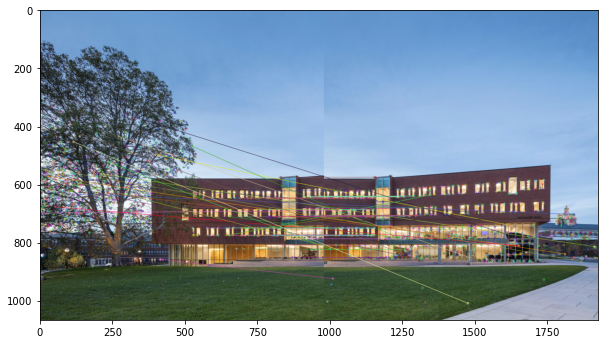

In [2]:
kp1=cv2.goodFeaturesToTrack(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), 1000, 0.1, 3)
kp2=cv2.goodFeaturesToTrack(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), 1000, 0.1, 3)
kp1= [cv2.KeyPoint(float(x[0][0]), float(x[0][1]), 1) for x in kp1]
kp2= [cv2.KeyPoint(float(x[0][0]), float(x[0][1]), 1) for x in kp2]
sift = cv2.SIFT_create()
k1, d1 = sift.compute(img1,kp1)
k2, d2 = sift.compute(img2,kp2)
img,_=findMatch(img1,k1,d1,img2,k2,d2)   
plt.figure(figsize=(10, 15))
plt.imshow(img)
plt.show()

Because of the drawback of the harris corner, the state of the art approach: SIFT comes in.  
You don't have to spend much time to find the good parameter, it'll find the keypoints and descriptor at once

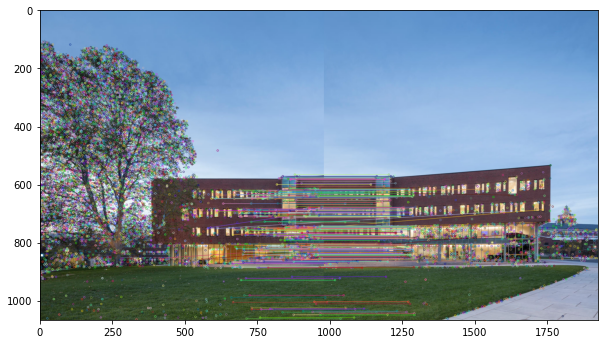

In [3]:
k1, d1 = sift.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY),None)
k2, d2 = sift.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY),None)
img,matches=findMatch(img1,k1,d1,img2,k2,d2)  
plt.figure(figsize=(10, 15))
plt.imshow(img)
plt.show()

### Problem 2.1  Image stitching
As you can see, although we can find good matches between two images, there are still many outliers(mismatch).    
Because of these outliers, we cannot use simple regression to find the transformation between two images.  
Therefore we need to implement RANSAC which is a general framework for model fitting in the presence of outliers.

We use homogeneous coordinates here, which means representing a 2D vector (x, y) as a 3D vector (x, y, 1).

Fitting with perspective matrix means given a set of matched feature points $\{p1,p2\}$ we want to find a `3*3` Projective Transform (Homography) matrix $\mathcal{H}$ so that
$$
w*p_2 =  \mathcal{H} * p_1, 
$$
where $w$ is a unknown scale factor.





#### a. Given four matches Compute $\mathcal{H}$ with Direct Linear Transform
>Hint: you might need to use `np.linalg.svd()` to compute the SVG decomposition.
>https://courses.cs.washington.edu/courses/cse576/16sp/Slides/10_ImageStitching.pdf
>But in the case of homography, each correspondence solves two constraints. Hence 
only 4 correspondence points are sufficient.

In [4]:
import numpy as np
def computeHomographyMatrix(fourcorrs):
    
    """ Compute H using DLT with four point correspondences
    P is 8 by 9 matrix, there are 8 constraints in H matrix """

    P = np.array([
     [fourcorrs[0][0][0]*-1, fourcorrs[0][0][1]*-1, -1, 0, 0, 0, fourcorrs[0][1][0]*fourcorrs[0][0][0], fourcorrs[0][1][0]*fourcorrs[0][0][1], fourcorrs[0][1][0]],
     [0 ,0 ,0 ,fourcorrs[0][0][0]*-1, fourcorrs[0][0][1]*-1, -1, fourcorrs[0][1][1]*fourcorrs[0][0][0], fourcorrs[0][1][1]*fourcorrs[0][0][1], fourcorrs[0][1][1]],
     [fourcorrs[1][0][0]*-1, fourcorrs[1][0][1]*-1, -1, 0, 0, 0, fourcorrs[1][1][0]*fourcorrs[1][0][0], fourcorrs[1][1][0]*fourcorrs[1][0][1], fourcorrs[1][1][0]],
     [0 ,0 ,0 ,fourcorrs[1][0][0]*-1, fourcorrs[1][0][1]*-1, -1, fourcorrs[1][1][1]*fourcorrs[1][0][0], fourcorrs[1][1][1]*fourcorrs[1][0][1], fourcorrs[1][1][1]],
     [fourcorrs[2][0][0]*-1, fourcorrs[2][0][1]*-1, -1, 0, 0, 0, fourcorrs[2][1][0]*fourcorrs[2][0][0], fourcorrs[2][1][0]*fourcorrs[2][0][1], fourcorrs[2][1][0]],
     [0 ,0 ,0 ,fourcorrs[2][0][0]*-1, fourcorrs[2][0][1]*-1, -1, fourcorrs[2][1][1]*fourcorrs[2][0][0], fourcorrs[2][1][1]*fourcorrs[2][0][1], fourcorrs[2][1][1]],
     [fourcorrs[3][0][0]*-1, fourcorrs[3][0][1]*-1, -1, 0, 0, 0, fourcorrs[3][1][0]*fourcorrs[3][0][0], fourcorrs[3][1][0]*fourcorrs[3][0][1], fourcorrs[3][1][0]],
     [0 ,0 ,0 ,fourcorrs[3][0][0]*-1, fourcorrs[3][0][1]*-1, -1, fourcorrs[3][1][1]*fourcorrs[3][0][0], fourcorrs[3][1][1]*fourcorrs[3][0][1], fourcorrs[3][1][1]]])
    
    """ SVG decomposition, Vt = V* are real orthogonal matrices, last column of 𝑉 (i.e: the last row of Vt)
    should be the homography matrix """
    
    [U, S, Vt] = np.linalg.svd(P)
    homography = Vt[-1,:].reshape(3, 3)
    homography = homography / homography[2][2]
    
    return homography   

#### b. Count inliers with geometric distance
After you finding the transform matrix, you need to find the fraction of inliers within a preset threshold of the model.  
Specifically, we iterate through all matched points and if
$$
||p_2 - p_1*\mathcal{H}||<threshold
$$
we'll consider this match as a inlier.

You need to return all inliers with below function.

In [5]:
import numpy as np
def getInliers(corrList, h, threshold=5):
    inliers = []
    for corr in corrList:
        p2 = np.array([[corr[1][0]],[corr[1][1]],[1]])
        p1 = np.array([[corr[0][0]],[corr[0][1]],[1]])
        distance = np.linalg.norm(p2 - h.dot(p1))
        if distance < 5:
            inliers.append(corr)
    return inliers

#### c. RANSAC

RANSAC outline:  

1. Randomly select four matches. 
>Hint: you can use `random.sample()` to randome select from a list.
2. Solve for $\mathcal{H}$ parameters using sampled matches. Use `computeHomographyMatrix()` defined above.
3. Find all inliners with last step $\mathcal{H}$. Use `getInliers()` defined above.

Repeat 1-3 until # of inliners is greater than (# of all matches) * threshold, then return $\mathcal{H}$

In [6]:
def ransac(corrList, thresh):
    i=0
    while i <= len(corrList) * thresh:
        fourcorrs = random.sample(corrList, 4)
        H_matrix = computeHomographyMatrix(fourcorrs)
        in_list = getInliers(corrList, H_matrix, threshold=5)
        i = len(in_list)
    return H_matrix

#### d.Perspectative tranformation

After getting the transformation between two images, the last step is to stitch them together.  
>Hint:You can use `cv2.perspectiveTransform` in your implementation to transform the image.

In [7]:
def stitch(img1,img2,H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0,rows2], [cols2, rows2], [cols2,0]]).reshape(-1,1,2)
    temp_points = np.float32([[0,0], [0,rows1], [cols1, rows1], [cols1,0]]).reshape(-1,1,2)

    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0,0,1]])

    output_img = cv2.warpPerspective(img1, H_translation.dot(H), (x_max - x_min, y_max - y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1],translation_dist[0]:cols1+translation_dist[0]] = img2
    return output_img

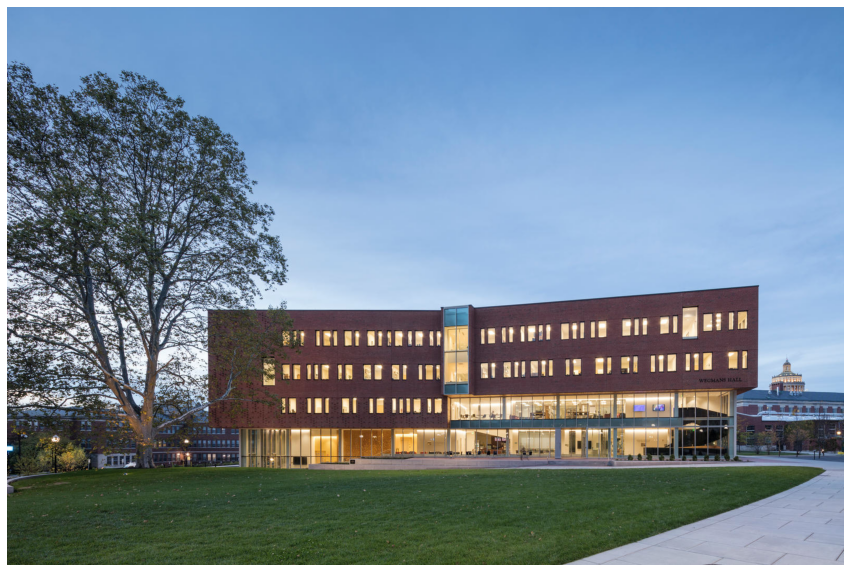

In [8]:
corrList = []
for match in matches:
    (x1, y1) = k1[match.queryIdx].pt
    (x2, y2) = k2[match.trainIdx].pt
    corrList.append([(x1, y1), (x2, y2)])
H= ransac(corrList, 0.6)
result = stitch(img1,img2,H)
plt.figure(figsize=(15,20))
plt.axis('off')
plt.imshow(result)
plt.show()

### Problem 2.2 Hough Transform (CSC 449 ONLY and extra bonus for CSC 249)
Find the coordinates and radius of these circles.

Use the Hough Transform with right $R$ first to transform the image to parameter space, and then find the local maximum as coordinate.

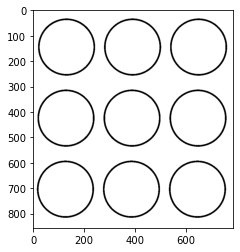

In [3]:
img = cv2.cvtColor(cv2.imread(str(data/'circles.png')), cv2.COLOR_BGR2GRAY)
img[img<img.max()*0.5]=0
img[img>0]=255
plt.imshow(img,cmap='gray')

Find center coordinates and radius of these circles

#### a. Hough transform
No build-in functions are al

In [5]:
import math
def houghtrans(img,R):
    accum = np.zeros((img.shape[0],img.shape[1]))
    pixel = np.argwhere(img==0)
    pixel = random.sample(pixel.tolist(), 360)
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            for p in pixel:
                xpart = (i - p[0])**2
                ypart = (j - p[1])**2
                l = math.sqrt(xpart + ypart)
                if (abs(l-R) < 0.5):
                    accum[i][j] += 1
    return accum

#### b.Detect local maxmium

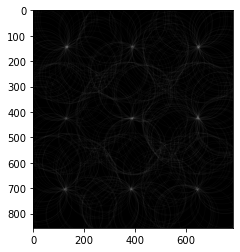

In [14]:
accum = houghtrans(img,111)
plt.imshow(accum,cmap='gray')

In [47]:
# using a window find local maxima
kp=[]
for x in range(accum.shape[0]):
    for y in range(accum.shape[1]):
        if (x >= 120 and x <= accum.shape[0]-120) and (y >=120 and y <= accum.shape[1]-120):
            if accum[x][y] == np.max(accum[x-120:x+120,y-120:y+120]) and accum[x][y]>=8: 
                if all(math.sqrt((x-pt[0])**2+(y-pt[1])**2)>10 for pt in kp) or len(kp)==0:
                    kp.append([x,y])
kp                  

[[143, 390],
 [144, 135],
 [149, 648],
 [420, 649],
 [424, 131],
 [425, 389],
 [702, 128],
 [703, 387],
 [703, 644]]

We find the index of nine local maximas and the radius is about 111.
Note that: these are indexes we need to switch y and x to get coordinates. 
Coordinates for circle centers (local maxima) are (135,144), (131,424), (128,702), (390,143), 
(389,425), (387,703), (648,149), (649,420), (644,703)